In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.8 MB/s eta 0:00:00


# get climate data

In [ ]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import pandas as pd
import io

def read_and_aggregate_data(file_path, variable_name):
    # Configure boto3 to access the public bucket without signing requests
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    try:
        # Download the dataset from S3
        response = s3.get_object(Bucket='wbg-cckp', Key=file_path)
        data_stream = io.BytesIO(response['Body'].read())
        data = xr.open_dataset(data_stream)  # Open the dataset

        # Define the coordinate ranges for the three regions
        regions = [
            {"lat": slice(1, 7), "lon": slice(100, 105)},       # Peninsular Malaysia
            {"lat": slice(4, 7.5), "lon": slice(115.5, 119.3)}, # Sabah
            {"lat": slice(2, 4), "lon": slice(112, 114.6)},     # Sarawak
        ]

        # Aggregate data for all regions combined
        aggregated_values = []
        for coords in regions:
            subset_data = data.sel(lat=coords["lat"], lon=coords["lon"])  # Subset for region
            region_aggregated_data = subset_data[variable_name].mean(dim=['lat', 'lon'])
            aggregated_values.append(region_aggregated_data)

        # Combine the aggregated values for all regions
        combined_data = sum(aggregated_values) / len(regions)
        df = combined_data.to_dataframe().reset_index()
        data.close()  # Close the dataset

        return df

    except Exception as e:
        print(f"Error accessing or processing the file: {e}")
        return None


In [ ]:
def create_dataframe(v):
  base_url = f"data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-historical/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc"
  variable = f"timeseries-{v}-monthly-mean"
  data = read_and_aggregate_data(base_url, variable)
  data = data.rename(columns={f'timeseries-{v}-monthly-mean': v})

  return data

In [ ]:
pr = create_dataframe('pr')
tas = create_dataframe('tas')
hurs = create_dataframe('hurs')
tasmin = create_dataframe('tasmin')
tasmax = create_dataframe('tasmax')
prpercnt = create_dataframe('prpercnt') # Precipitation Percent Change
cdd = create_dataframe('cdd') # Max number of consecutive dry days
cwd = create_dataframe('cwd') # Max Number of Consecutive Wet Days
sd = create_dataframe('sd') # Number of Summer Days (Tmax > 25°C)
spei12 = create_dataframe('spei12') # drought index

In [ ]:
cdd['cdd'] = cdd['cdd'].dt.total_seconds() / (60*60*24)
cwd['cwd'] = cwd['cwd'].dt.total_seconds() / (60*60*24)
sd['sd'] = sd['sd'].dt.total_seconds() / (60*60*24)

In [ ]:
import pandas as pd

dfs = [pr, prpercnt, hurs, spei12, tas, tasmin, tasmax, cdd, cwd, sd]
historical_climate = dfs[0]

# Extract Year and Month before merging
historical_climate[['Year', 'Month']] = historical_climate['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
historical_climate[['Year', 'Month']] = historical_climate[['Year', 'Month']].astype(int)

for df in dfs[1:]:
    historical_climate = pd.merge(historical_climate, df, on=['time'])  # Merge on 'Date'

# Reorder columns after merging
historical_climate = historical_climate.rename(columns={'time': 'Date'})
cols = ['Year', 'Month'] + [col for col in historical_climate.columns if col not in ['Year', 'Month']]
historical_climate = historical_climate[cols]

historical_climate = historical_climate[historical_climate['Year'] >= 1984]
historical_climate.to_csv('historical_climate_v4.csv', index=False)


# get palm oil data

In [57]:
import pandas as pd

# Get Fresh Fruit Bunch (FFB) Yield data
ffb = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Yield (Malaysia)', skiprows=3)
ffb = ffb.drop(columns='Unnamed: 0', index=[12,13,14])
ffb = pd.melt(ffb, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='FFB_Yield')
ffb = ffb.rename(columns={'YEAR\nMONTH': 'Month'})
ffb = ffb[['Year', 'Month', 'FFB_Yield']]
ffb['Month'] = pd.to_datetime(ffb['Month'], format='%B').dt.month

# Get Crude Palm Oil (CPO) Yield data
cpo = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'CPO Yield (Malaysia)', skiprows=3)
cpo = cpo.drop(columns='Unnamed: 0', index=[12,13,14])
cpo = pd.melt(cpo, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='CPO_Yield')
cpo = cpo.rename(columns={'YEAR\nMONTH': 'Month'})
cpo = cpo[['Year', 'Month', 'CPO_Yield']]
cpo['Month'] = pd.to_datetime(cpo['Month'], format='%B').dt.month

# Get Fresh Fruit Bunch (FFB) Production data
ffb2 = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Production', skiprows=4)
ffb2 = ffb2.drop(columns='Unnamed: 0', index=[12,13])
ffb2 = pd.melt(ffb2, id_vars=['Bulan'], var_name='Year', value_name='FFB_production')
ffb2 = ffb2.rename(columns={'Bulan': 'Month'})
ffb2 = ffb2[['Year', 'Month', 'FFB_production']]
month_mapping = {
    "Jan": 1, "Feb": 2, "Mac": 3, "Apr": 4, "Mei": 5, "Jun": 6,
    "Jul": 7, "Ogo": 8, "Sep": 9, "Okt": 10, "Nov": 11, "Dis": 12
} # mapping months
ffb2['Month'] = ffb2['Month'].map(month_mapping)

# merge the data
palm_oil = pd.merge(ffb, ffb2, on=['Year', 'Month'])
palm_oil = pd.merge(palm_oil, cpo, on=['Year', 'Month'])
palm_oil.to_csv('palm_oil.csv', index=False)


In [59]:
palm_oil.head(3)

,Year,Month,FFB_Yield,FFB_production,CPO_Yield
0,1987,1,1.09,1386360.0,0.21
1,1987,2,1.04,1360834.0,0.21
2,1987,3,1.08,1430449.0,0.22


# EDA

In [1]:
import pandas as pd
historical_climate = pd.read_csv('/content/historical_climate_v4.csv')
historical_climate.describe()

,Year,Month,pr,prpercnt,hurs,spei12,tas,tasmin,tasmax,cdd,cwd,sd
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,1999.000000,6.500000,222.829715,98.919030,82.355433,-0.075109,26.499710,23.895222,29.104198,1.893139,25.235515,30.280730
std,8.956318,3.456702,59.606571,18.908860,1.148340,0.502137,0.548060,0.440187,0.678539,1.525517,4.504071,0.838166
min,1984.000000,1.000000,83.373055,45.070360,79.281944,-1.188180,25.011980,22.718649,27.305319,0.031111,9.469703,27.242442
25%,1991.000000,3.750000,179.003112,86.501638,81.577185,-0.418341,26.106200,23.599603,28.621465,0.728321,22.119255,29.913872
50%,1999.000000,6.500000,218.090425,99.476948,82.367793,-0.139086,26.564768,23.922649,29.239998,1.551101,26.017713,30.706337
75%,2007.000000,9.250000,264.940105,109.738812,83.135569,0.237094,26.863108,24.175253,29.595472,2.734982,29.326436,30.899925
max,2014.000000,12.000000,394.044680,162.384340,84.887695,1.234807,28.144142,25.388315,31.033249,10.949399,31.000000,31.000000


In [2]:
palm_oil = pd.read_csv('/content/palm_oil.csv')
palm_oil.head()

,Year,Month,FFB_Yield,FFB_production,CPO_Yield
0,1987,1,1.09,1386360.0,0.21
1,1987,2,1.04,1360834.0,0.21
2,1987,3,1.08,1430449.0,0.22
3,1987,4,1.20,1574587.0,0.24
4,1987,5,1.20,1628407.0,0.23


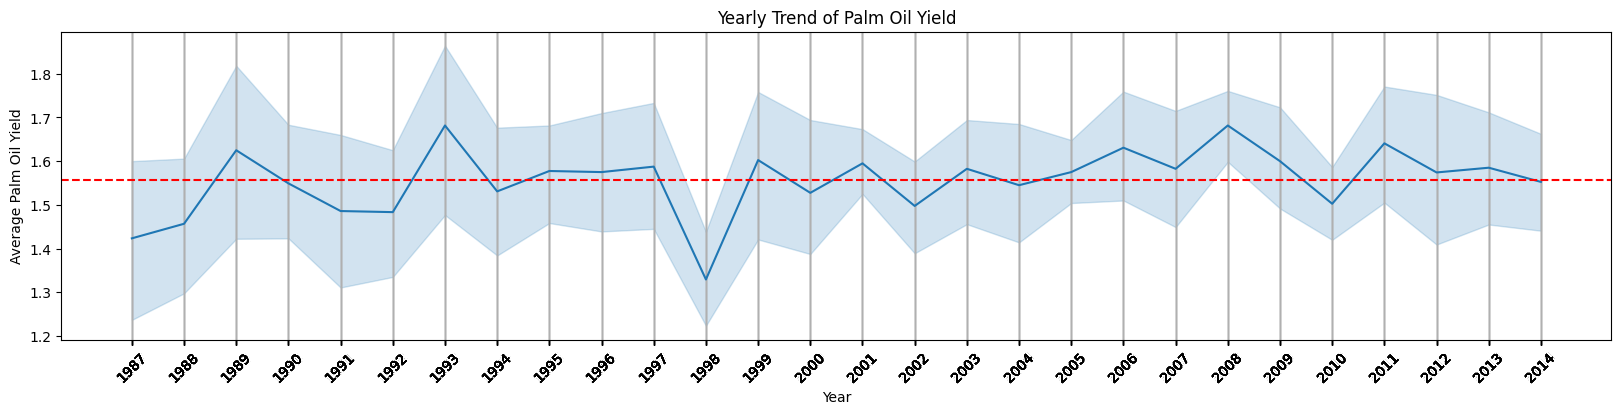

In [ ]:
# prompt: visualise yearly trend oil palm oil yield

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'palm_oil' DataFrame has a 'Year' and 'Yield' column
# palm_oil_yearly = palm_oil.groupby('Year')['FFB_Yield'].mean().reset_index()
# subset palmoil
palm_oil = palm_oil[palm_oil['Year'] <= 2014]
baseline_value = palm_oil['FFB_Yield'].mean()


plt.figure(figsize=(20, 4))
sns.lineplot(data=palm_oil, x='Year', y='FFB_Yield')
plt.axhline(y=baseline_value, color='r', linestyle='--', label='Baseline')
plt.xlabel('Year')
plt.xticks(palm_oil['Year'], rotation=45)
plt.ylabel('Average Palm Oil Yield')
plt.title('Yearly Trend of Palm Oil Yield')
plt.grid(axis='x')
plt.show()

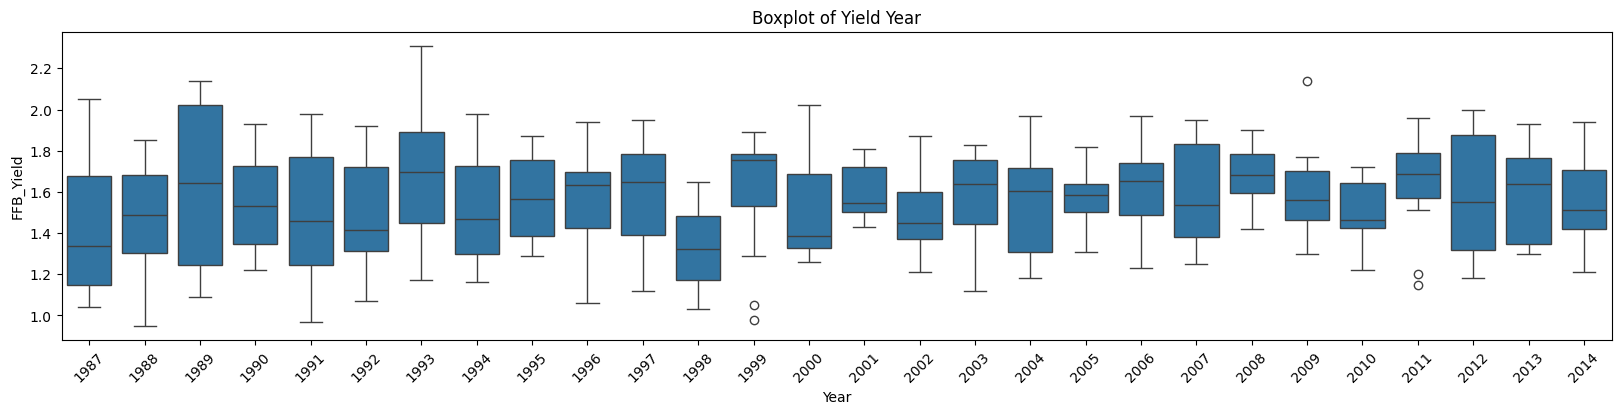

In [ ]:
# prompt: boxplot of pr by year
plt.figure(figsize=(20, 4))
sns.boxplot(x='Year', y='FFB_Yield', data=palm_oil)
plt.xlabel('Year')
plt.ylabel('FFB_Yield')
plt.title('Boxplot of Yield Year')
plt.xticks(rotation=45)
plt.show()

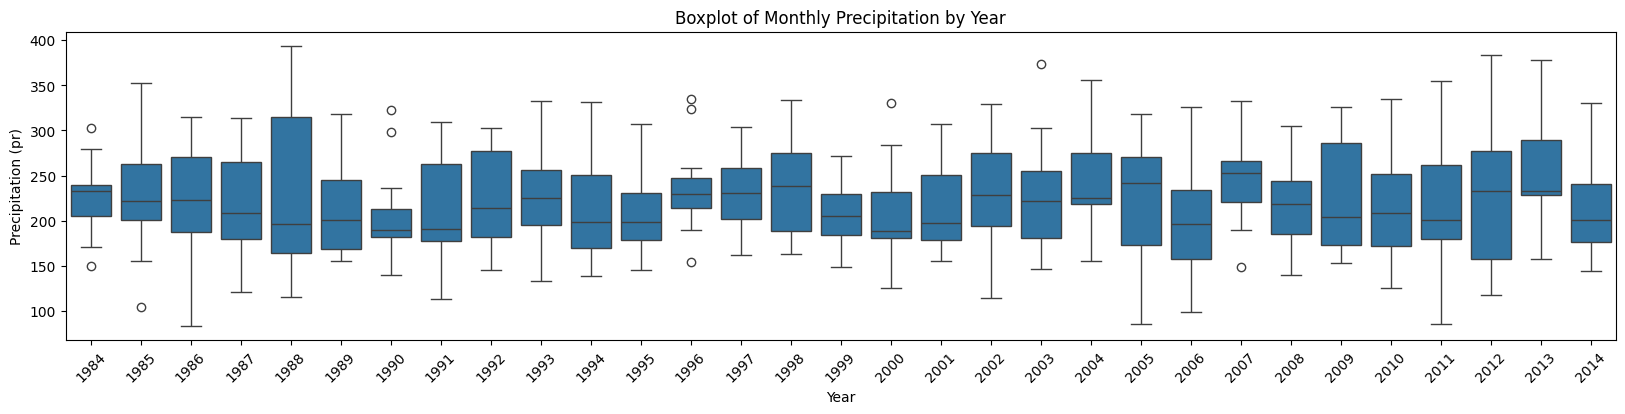

In [ ]:
# prompt: boxplot of pr by year
plt.figure(figsize=(20, 4))
sns.boxplot(x='Year', y='pr', data=historical_climate)
plt.xlabel('Year')
plt.ylabel('Precipitation (pr)')
plt.title('Boxplot of Monthly Precipitation by Year')
plt.xticks(rotation=45)
plt.show()

2673.9565803225805


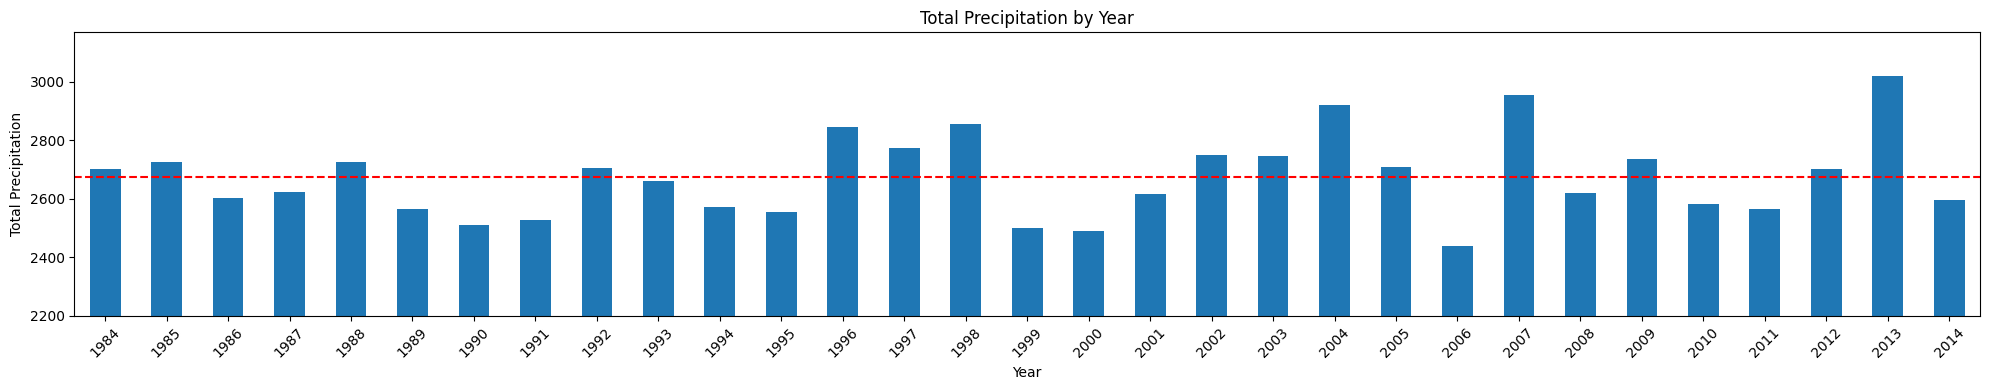

In [ ]:
# prompt: total percipitation by year

# Group the data by year and calculate the total precipitation for each year
yearly_precipitation = historical_climate.groupby('Year')['pr'].sum()
baseline = yearly_precipitation.mean()
print(baseline)

# Create a bar plot of total precipitation per year
plt.figure(figsize=(20, 4))
yearly_precipitation.plot(kind='bar')
plt.axhline(y=baseline, color='r', linestyle='--', label='Baseline')
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Total Precipitation by Year')
plt.xticks(rotation=45)
plt.ylim(bottom=2200)
plt.tight_layout()
plt.show()

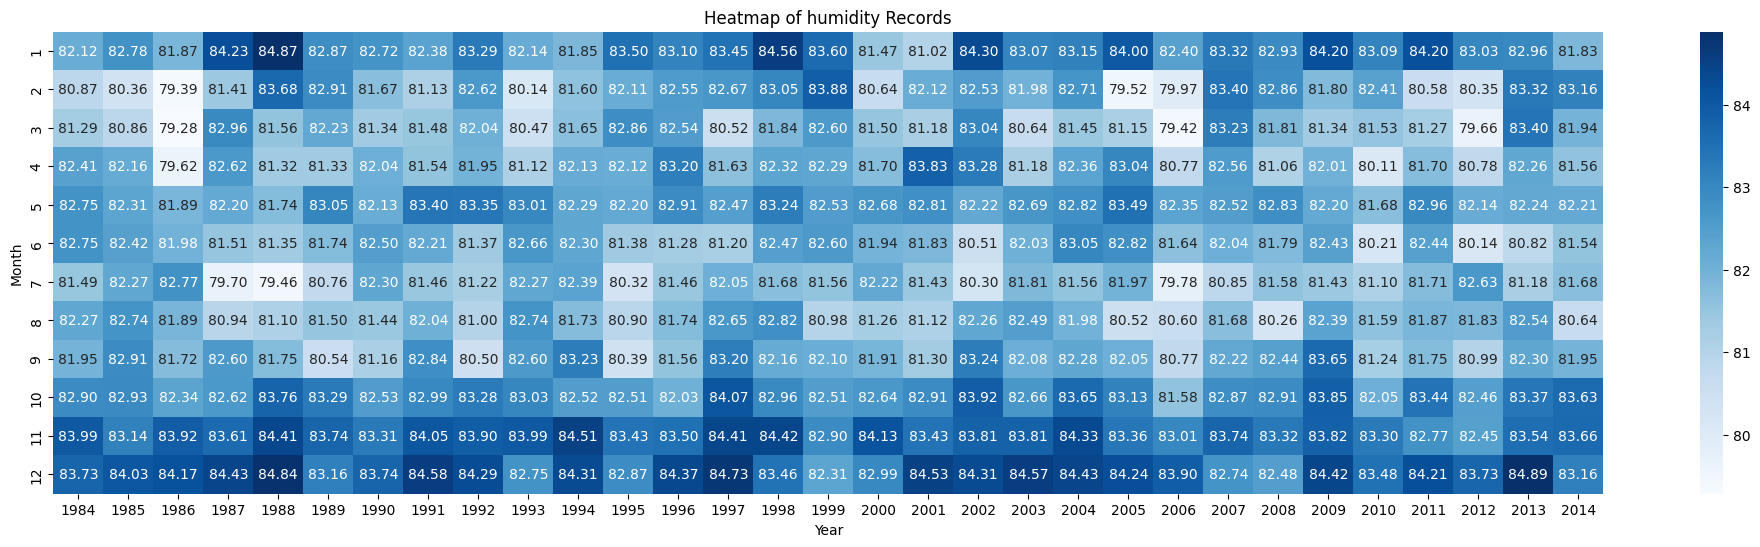

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(historical_climate.pivot_table(index='Month', columns='Year', values='hurs'), annot=True, fmt=".2f", cmap="Blues")
plt.title('Heatmap of humidity Records')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

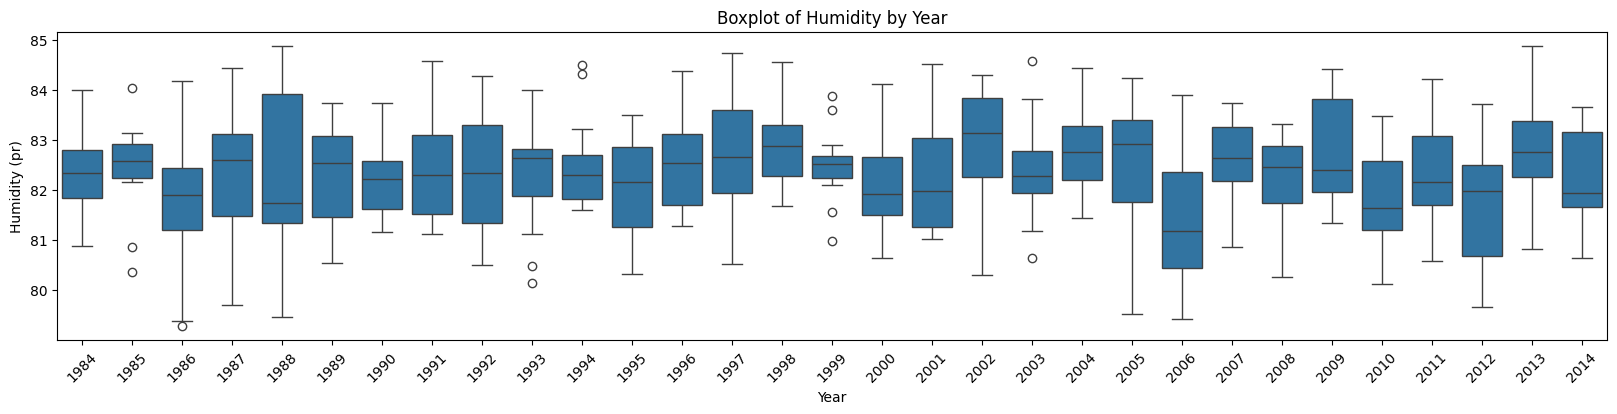

In [ ]:
plt.figure(figsize=(20, 4))
sns.boxplot(x='Year', y='hurs', data=historical_climate)
plt.xlabel('Year')
plt.ylabel('Humidity (pr)')
plt.title('Boxplot of Humidity by Year')
plt.xticks(rotation=45)
plt.show()

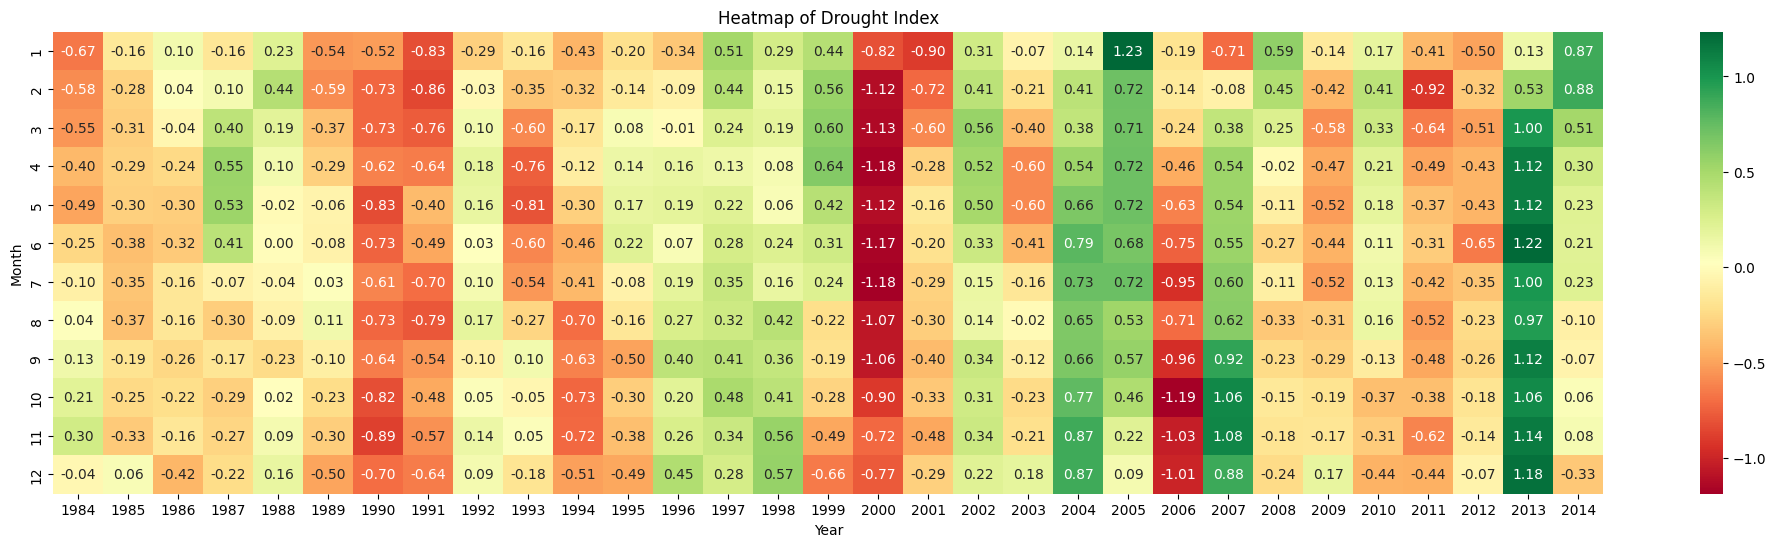

In [ ]:
# prompt: heatplot of year by month value is tas

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(historical_climate.pivot_table(index='Month', columns='Year', values='spei12'), annot=True, fmt=".2f", cmap="RdYlGn")
plt.title('Heatmap of Drought Index')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

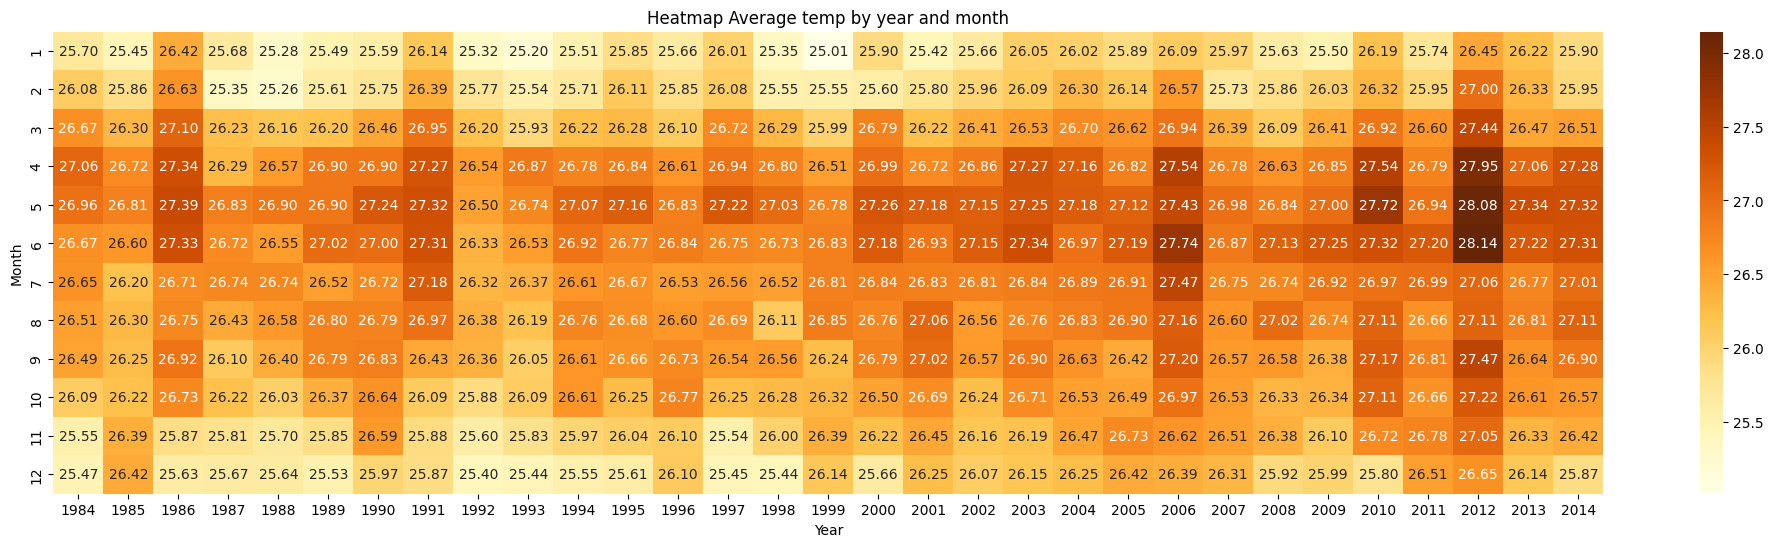

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(historical_climate.pivot_table(index='Month', columns='Year', values='tas'), annot=True, fmt=".2f", cmap="YlOrBr")
plt.title('Heatmap Average temp by year and month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

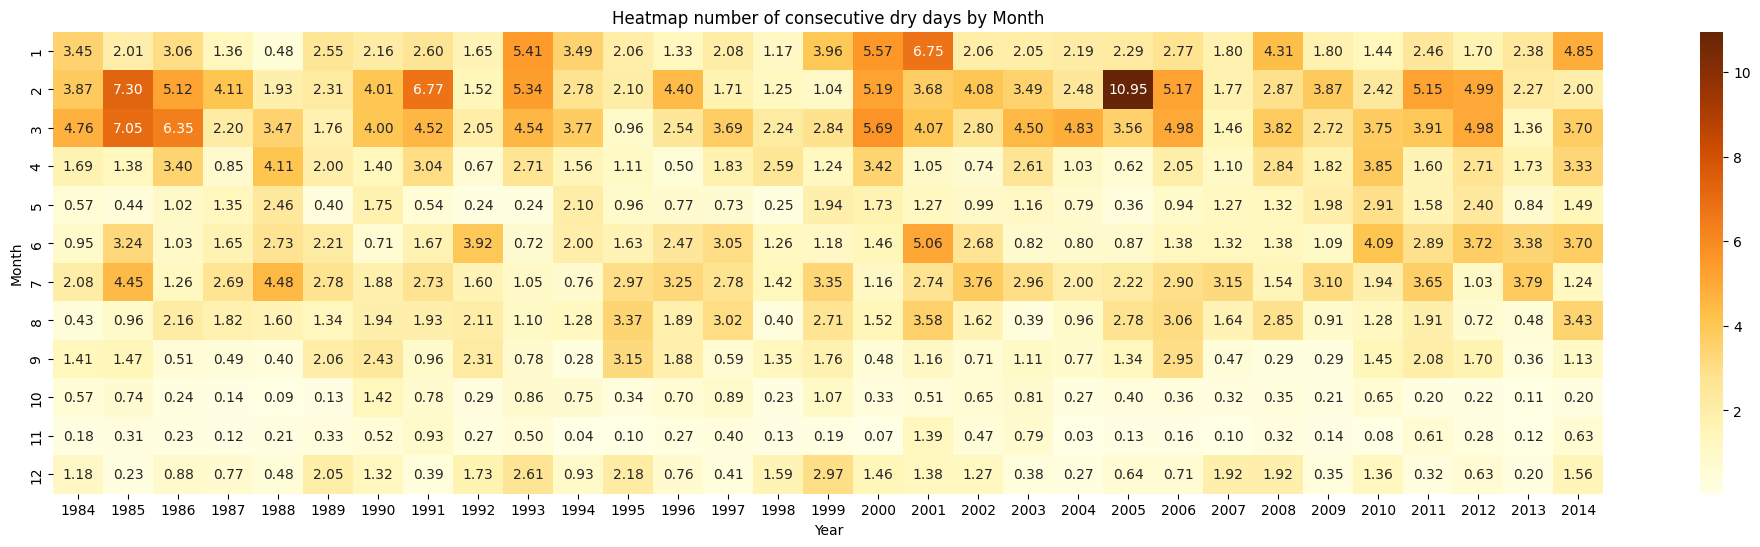

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(historical_climate.pivot_table(index='Month', columns='Year', values='cdd'), annot=True, fmt=".2f", cmap="YlOrBr")
plt.title('Heatmap number of consecutive dry days by Month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

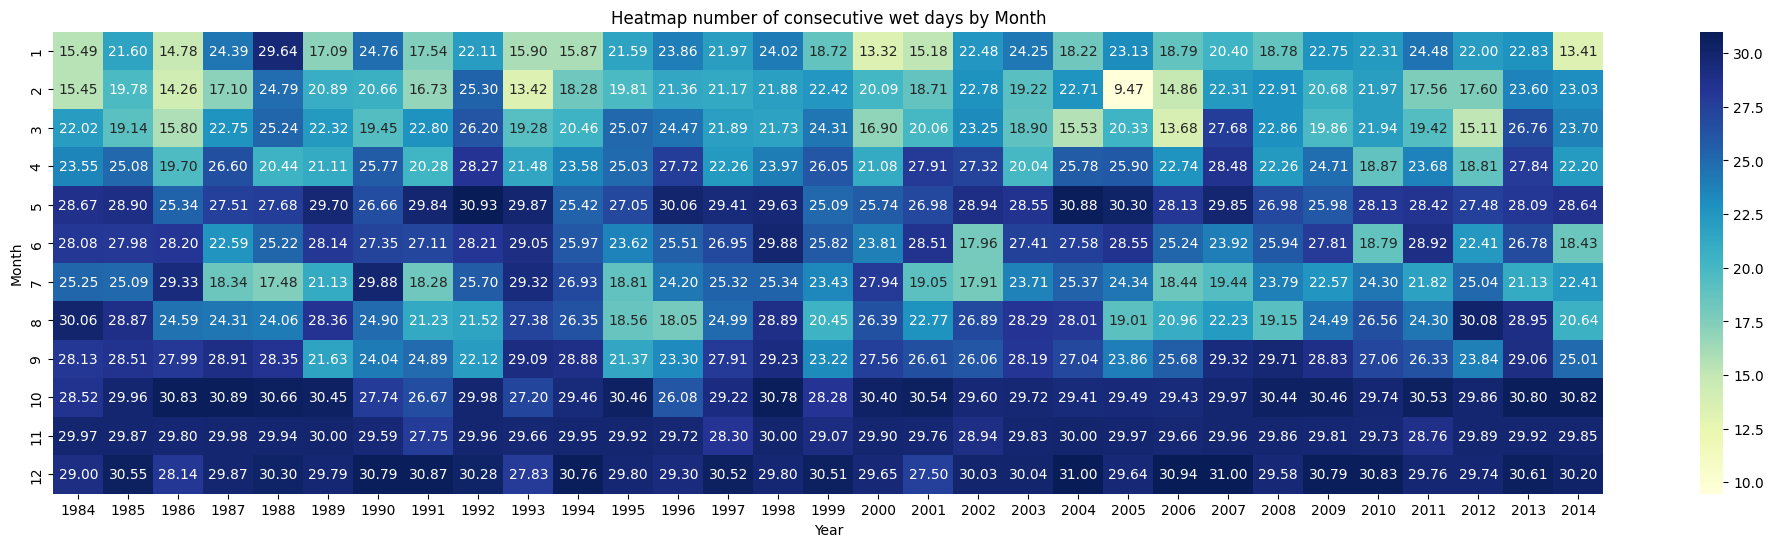

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(historical_climate.pivot_table(index='Month', columns='Year', values='cwd'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap number of consecutive wet days by Month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

In [3]:
# merge the historical climate data and palm oil data considering the 3 years lag
palm_oil['Year_Lag'] = palm_oil['Year'] - 3
data_lag = pd.merge(historical_climate, palm_oil, left_on=['Year', 'Month'], right_on=['Year_Lag', 'Month'], how='left')
data_lag = data_lag.rename(columns={'Year_x': 'Year_Climate', 'Year_y' :  'Year_Harvested'}).drop(columns='Year_Lag')


# Convert 'Date' column to datetime
data_lag['Date'] = pd.to_datetime(data_lag['Date'])

# calculate the temperature range
data_lag['tas_range'] = data_lag['tasmax'] - data_lag['tasmin']


# calculate the rolling precipitation of 3 years
data_lag['rolling_pr_3y'] = data_lag['pr'].rolling(36, 1).sum()
data_lag['rolling_pr_2y'] = data_lag['pr'].rolling(24, 1).sum()
data_lag['rolling_pr_1y'] = data_lag['pr'].rolling(12, 1).sum()

# reaarange the columns
data_lag = data_lag.dropna()
data_lag.head()

,Year_Climate,Month,Date,pr,prpercnt,hurs,spei12,tas,tasmin,tasmax,...,cwd,sd,Year_Harvested,FFB_Yield,FFB_production,CPO_Yield,tas_range,rolling_pr_3y,rolling_pr_2y,rolling_pr_1y
0,1984,1,1984-01-16,230.81274,83.798550,82.122000,-0.666611,25.699010,23.332530,28.065493,...,15.494507,30.713372,1987,1.09,1386360.0,0.21,4.732963,230.81274,230.81274,230.81274
1,1984,2,1984-02-16,149.66289,78.959930,80.872260,-0.582914,26.078674,23.513926,28.643425,...,15.449259,28.891667,1987,1.04,1360834.0,0.21,5.129499,380.47563,380.47563,380.47563
2,1984,3,1984-03-16,170.80202,98.041710,81.287880,-0.547782,26.666422,23.945307,29.387540,...,22.019401,30.951389,1987,1.08,1430449.0,0.22,5.442233,551.27765,551.27765,551.27765
3,1984,4,1984-04-16,225.56958,115.534874,82.406730,-0.402747,27.064331,24.394716,29.733942,...,23.546803,29.959722,1987,1.20,1574587.0,0.24,5.339226,776.84723,776.84723,776.84723
4,1984,5,1984-05-16,239.72563,107.818990,82.752754,-0.491950,26.963572,24.354116,29.573029,...,28.671389,30.919444,1987,1.20,1628407.0,0.23,5.218913,1016.57286,1016.57286,1016.57286


In [60]:
data_lag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Year_Climate    372 non-null    int64         
 1   Month           372 non-null    int64         
 2   Date            372 non-null    datetime64[ns]
 3   pr              372 non-null    float64       
 4   prpercnt        372 non-null    float64       
 5   hurs            372 non-null    float64       
 6   spei12          372 non-null    float64       
 7   tas             372 non-null    float64       
 8   tasmin          372 non-null    float64       
 9   tasmax          372 non-null    float64       
 10  cdd             372 non-null    float64       
 11  cwd             372 non-null    float64       
 12  sd              372 non-null    float64       
 13  Year_Harvested  372 non-null    int64         
 14  FFB_Yield       372 non-null    float64       
 15  FFB_pr

In [61]:
data_lag.describe()

,Year_Climate,Month,Date,pr,prpercnt,hurs,spei12,tas,tasmin,tasmax,...,cwd,sd,Year_Harvested,FFB_Yield,FFB_production,CPO_Yield,tas_range,rolling_pr_3y,rolling_pr_2y,rolling_pr_1y
count,372.000000,372.000000,372,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,...,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000
mean,1999.000000,6.500000,1999-07-01 20:15:29.032258048,222.829715,98.919030,82.355433,-0.075109,26.499710,23.895222,29.104198,...,25.235515,30.280730,2002.000000,1.546344,5.272846e+06,0.304086,5.208976,7622.125235,5175.476780,2632.065663
min,1984.000000,1.000000,1984-01-16 00:00:00,83.373055,45.070360,79.281944,-1.188180,25.011980,22.718649,27.305319,...,9.469703,27.242442,1987.000000,0.950000,1.342798e+06,0.180000,4.347259,230.812740,230.812740,230.812740
25%,1991.000000,3.750000,1991-10-08 12:00:00,179.003112,86.501638,81.577185,-0.418341,26.106200,23.599603,28.621465,...,22.119255,29.913872,1994.000000,1.350000,3.285593e+06,0.270000,4.972045,7789.234728,5174.966475,2556.227560
50%,1999.000000,6.500000,1999-07-01 00:00:00,218.090425,99.476948,82.367793,-0.139086,26.564768,23.922649,29.239998,...,26.017713,30.706337,2002.000000,1.555000,5.186810e+06,0.300000,5.277792,7942.553337,5323.370790,2650.864400
75%,2007.000000,9.250000,2007-03-23 18:00:00,264.940105,109.738812,83.135569,0.237094,26.863108,24.175253,29.595472,...,29.326436,30.899925,2010.000000,1.740000,7.023259e+06,0.340000,5.442715,8194.159750,5458.953631,2762.546673
max,2014.000000,12.000000,2014-12-16 00:00:00,394.044680,162.384340,84.887695,1.234807,28.144142,25.388315,31.033249,...,31.000000,31.000000,2017.000000,2.310000,1.008588e+07,0.440000,5.867093,8475.250420,5859.595160,3120.930580
std,8.956318,3.456702,NaN,59.606571,18.908860,1.148340,0.502137,0.548060,0.440187,0.678539,...,4.504071,0.838166,8.956318,0.259910,2.241425e+06,0.053235,0.326925,1400.751955,787.764816,307.211316


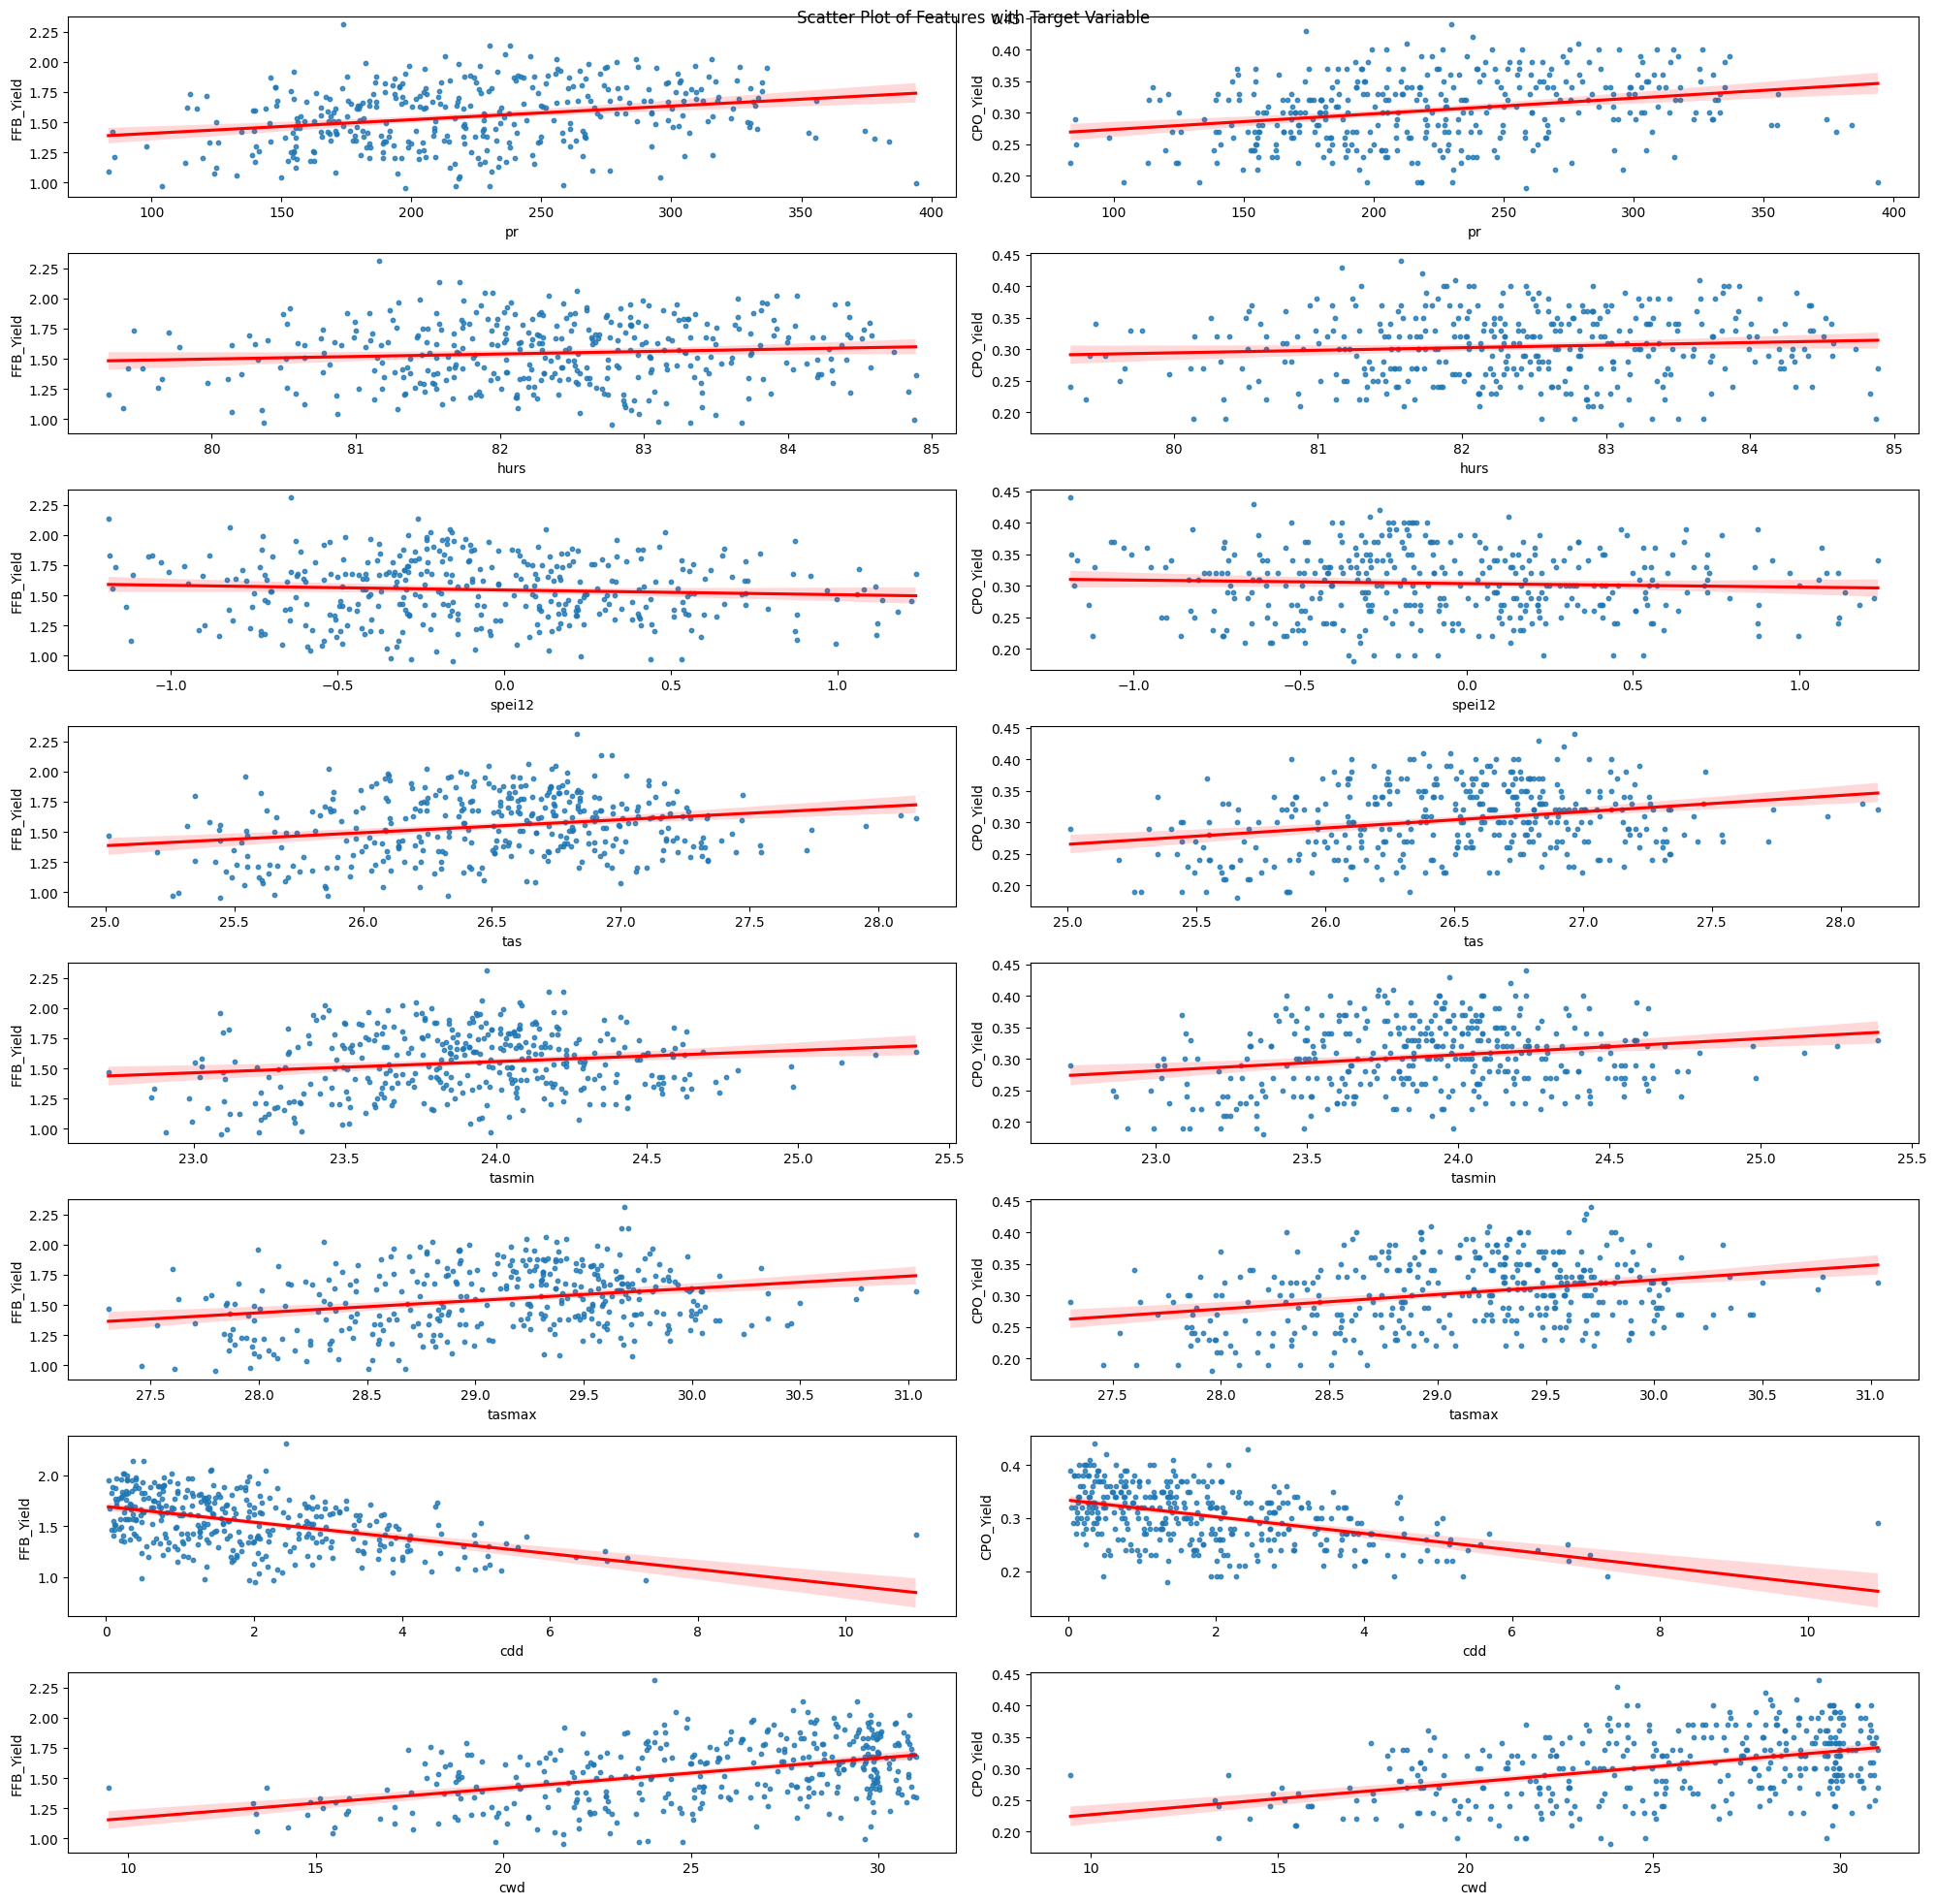

In [4]:
climate_features = ['pr', 'hurs', 'spei12', 'tas', 'tasmin', 'tasmax', 'cdd', 'cwd']
target = ['FFB_Yield','CPO_Yield']

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(len(climate_features), len(target), figsize=(20, 20))
fig.suptitle('Scatter Plot of Features with Target Variable')

for i, target_var in enumerate(climate_features):
    for j, feature in enumerate(target):
        sns.regplot(ax=axes[i, j], x=data_lag[target_var], y=data_lag[feature], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[i, j].set_ylabel(feature)
        axes[i, j].set_xlabel(target_var)

plt.tight_layout()
plt.show()

In [ ]:
data_lag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 335
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Year_Climate    336 non-null    int64         
 1   Month           336 non-null    int64         
 2   Date            336 non-null    datetime64[ns]
 3   pr              336 non-null    float64       
 4   prpercnt        336 non-null    float64       
 5   hurs            336 non-null    float64       
 6   spei12          336 non-null    float64       
 7   tas             336 non-null    float64       
 8   tasmin          336 non-null    float64       
 9   tasmax          336 non-null    float64       
 10  cdd             336 non-null    float64       
 11  cwd             336 non-null    float64       
 12  sd              336 non-null    float64       
 13  Year_Harvested  336 non-null    float64       
 14  FFB_Yield       336 non-null    float64       
 15  FFB_product

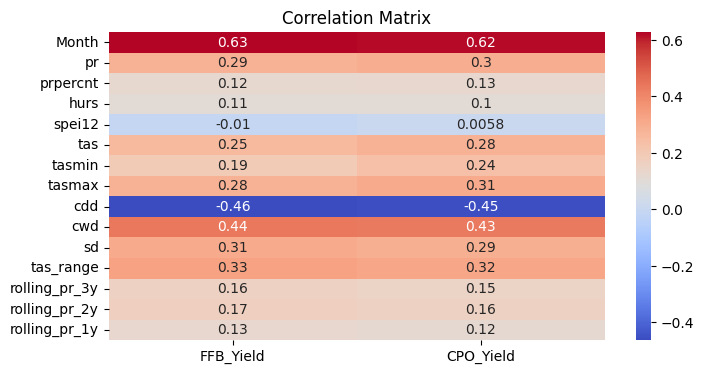

In [ ]:
target = ['FFB_Yield','CPO_Yield']
climate_features = data_lag.drop(target, axis=1).columns
time_features = ['Year_Climate', 'Year_Harvested', 'Date']

correlation = data_lag.corr()
correlation = correlation[target]
correlation = correlation.drop(target + time_features + ['FFB_production'], axis=0)

plt.figure(figsize=(8, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Modelling

In [11]:
# define variables and target
from sklearn.model_selection import train_test_split

X = data_lag.drop(columns=['FFB_Yield', 'FFB_production',
                           'CPO_Yield', 'Year_Climate',
                           'Year_Harvested', 'Date'])
y = data_lag['FFB_Yield']

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_sscaled = scaler.fit_transform(X)

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

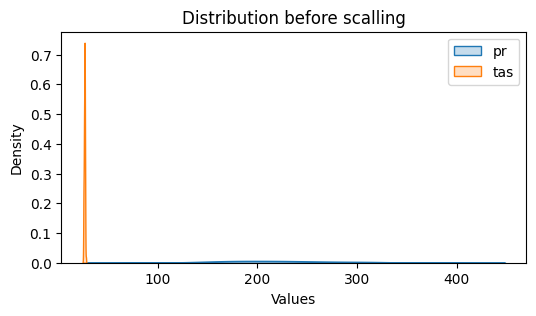

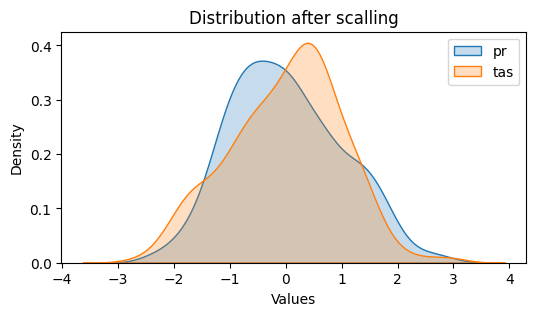

In [56]:
# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt

# data = data_lag.drop(['Year_Climate', 'Year_Harvested', 'FFB_Yield', 'FFB_production', 'CPO_Yield', 'rolling_pr_3y'], axis=1)
data = data_lag[['pr', 'tas']]

# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('Distribution before scalling')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

ss_scaler = StandardScaler()

# data = data_lag.drop(['Year_Climate', 'Year_Harvested', 'FFB_Yield', 'FFB_production', 'CPO_Yield', 'rolling_pr_3y'], axis=1)
data = data_lag[['pr', 'tas']]

data = pd.DataFrame(ss_scaler.fit_transform(data), columns=data.columns)

# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('Distribution after scalling')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()


In [12]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# method to train and append model results to the results table
trained_models = {}
def train_and_append_results(model, resultstable, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Perform cross-validation and calculate evaluation metrics
    mse_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
    mae_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

    # Calculate mean and standard deviation of the scores
    mse_mean = -mse_scores.mean()
    mse_std = mse_scores.std()
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()
    mae_mean = -mae_scores.mean()
    mae_std = mae_scores.std()

    # Fit the model to the entire training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Append the results to the table
    resultstable.loc[len(resultstable)] = [
        model.__class__.__name__,
        mse_mean, mse_std,
        rmse_mean, rmse_std,
        mae_mean, mae_std,
        r2_mean, r2_std
    ]

    # Store the trained model and predictions
    trained_models[model.__class__.__name__] = {'model': pipeline, 'y_pred': y_pred}

In [23]:
# define results table
results_ffb = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
results_ffb = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std'])

# Define the models
ffb_model_LR = LinearRegression() # linear regression model
ffb_model_DTR = DecisionTreeRegressor(random_state=42) # Decision Tree Regressor model
ffb_model_RFR = RandomForestRegressor(random_state=42)  # Random Forest Regressor model
# ffb_model_SVR = SVR() # Support Vector Regressor model
# ffb_model_GBR = GradientBoostingRegressor(random_state=42)
ffb_model_ABR = AdaBoostRegressor(random_state=42)
ffb_model_ETR = ExtraTreesRegressor(random_state=42)  # Extra Trees Regressor model

train_and_append_results(ffb_model_LR, results_ffb)
train_and_append_results(ffb_model_DTR, results_ffb)
train_and_append_results(ffb_model_RFR, results_ffb)
# train_and_append_results(ffb_model_SVR, results_ffb)
# train_and_append_results(ffb_model_GBR, results_ffb)
train_and_append_results(ffb_model_ABR, results_ffb)
train_and_append_results(ffb_model_ETR, results_ffb)

results_ffb.sort_values('R2 Mean', ascending=False)

,Model,MSE Mean,MSE Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,R2 Mean,R2 Std
2,RandomForestRegressor,0.027036,0.002553,0.164238,0.007886,0.134082,0.007324,0.597956,0.066012
3,AdaBoostRegressor,0.027745,0.002447,0.166406,0.007339,0.134021,0.006722,0.588166,0.063477
4,ExtraTreesRegressor,0.028350,0.003654,0.168033,0.010721,0.136972,0.009915,0.578584,0.081852
0,LinearRegression,0.031706,0.003389,0.177809,0.009479,0.140579,0.011333,0.531496,0.064887
1,DecisionTreeRegressor,0.049224,0.009221,0.220812,0.021589,0.176514,0.018750,0.267629,0.161481


In [24]:
best_model_name = results_ffb.loc[results_ffb['R2 Mean'].idxmax()]['Model']
best_pipeline = trained_models[best_model_name]['model']
best_model = best_pipeline.named_steps['model']
best_model_metrics = results_ffb[results_ffb['Model'] == best_model_name].iloc[0]  # Get metrics row
best_model_y_pred = trained_models[best_model_name]['y_pred']

print(f"Evaluation Metrics for the Best Model: {best_model_name}")
for metric in ['MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std']:
    print(f"{metric}: {best_model_metrics[metric]}")

Evaluation Metrics for the Best Model: RandomForestRegressor
MSE Mean: 0.02703617787231639
MSE Std: 0.002552604800603515
RMSE Mean: 0.1642375987739504
RMSE Std: 0.007886001603048615
MAE Mean: 0.13408198870056495
MAE Std: 0.007323779321450083
R2 Mean: 0.5979557820512779
R2 Std: 0.06601190701397615


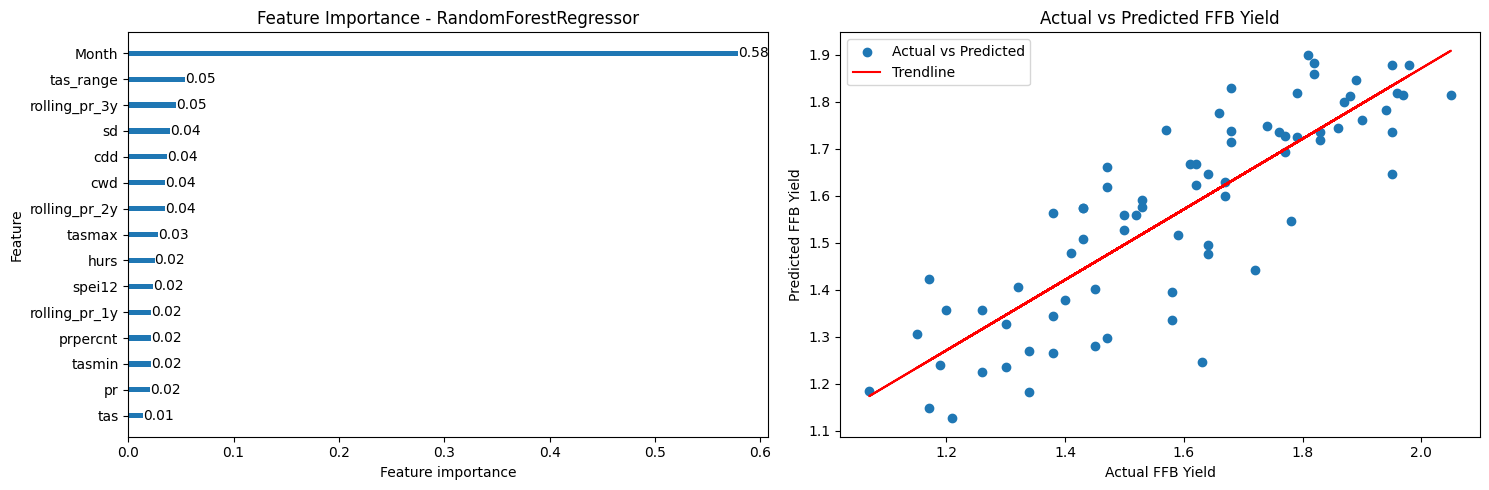

In [25]:
import numpy as np
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [28]:
# get model parameters
for p in best_model.get_params():
    print(f'{p}: {best_model.get_params()[p]}')

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [30]:
param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

from sklearn.model_selection import RandomizedSearchCV

tuned_model = RandomizedSearchCV(estimator = best_pipeline, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, scoring='r2')
tuned_model.fit(X_train, y_train)
print("Best Parameters:", tuned_model.best_params_)
print("Best Score:", tuned_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 5}
Best Score: 0.6095571147098064


In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Predict using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate evaluation metrics for the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# Create a comparison table using Pandas DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'base_model': [best_model_metrics['MSE Mean'], best_model_metrics['RMSE Mean'], best_model_metrics['MAE Mean'], best_model_metrics['R2 Mean']],
    'tuned_model': [mse_tuned, rmse_tuned, mae_tuned, r2_tuned],
    'improvement %': [(best_model_metrics['MSE Mean'] - mse_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (best_model_metrics['RMSE Mean'] - rmse_tuned)/best_model_metrics['RMSE Mean'] * 100,
                    (best_model_metrics['MAE Mean'] - mae_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (r2_tuned - best_model_metrics['R2 Mean'])/best_model_metrics['R2 Mean'] * 100]

})

# Display the comparison table
print('Comparison of FFB model')
print(comparison_df)
print()
print(f'Improvement')

Comparison of FFB model
  Metric  base_model  tuned_model  improvement %
0    MSE    0.027036     0.017234       7.310364
1   RMSE    0.164238     0.131279      20.067353
2    MAE    0.134082     0.105604      21.239410
3     R2    0.597956     0.705873      18.047626

Improvement


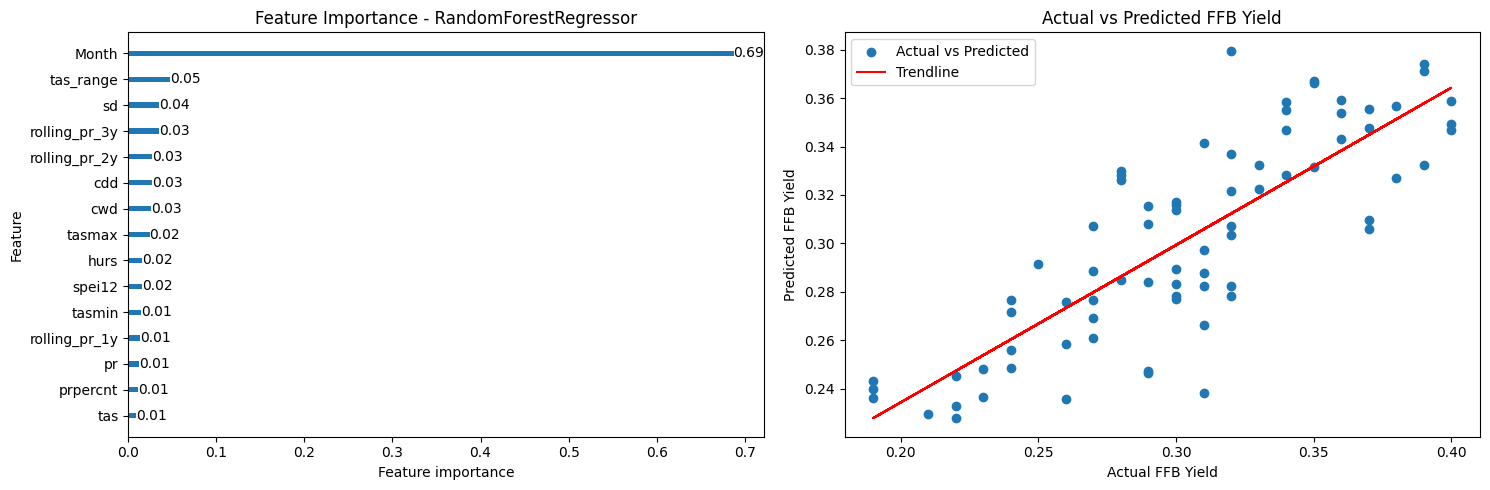

In [48]:
import numpy as np
import matplotlib.pyplot as plt
best_pipeline = tuned_model.best_estimator_
best_tuned_model = best_pipeline.named_steps['model']

importances = best_tuned_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [34]:
import joblib

joblib.dump(tuned_model, 'ffb_yield_model5.pkl')

['ffb_yield_model5.pkl']

In [35]:
dummy_data = pd.DataFrame([[1, 100, 150, 80, 0.3, 25, 22, 30, 6.4, 25, 31, 8, 3600, 2400, 1200]],
                          columns=['Month', 'pr', 'prpercnt', 'hurs', 'spei12', 'tas', 'tasmin', 'tasmax','cdd', 'cwd', 'sd', 'tas_range', 'rolling_pr_3y', 'rolling_pr_2y', 'rolling_pr_1y'])



In [42]:
model4 = joblib.load('ffb_yield_model4.pkl')
v4 = model4.predict(X)

model5 = joblib.load('ffb_yield_model5.pkl')
v5 = model5.predict(X)

print(f'model v4: {r2_score(y, v4)}')
print(f'model v5: {r2_score(y, v5)}')

model v5: 0.8037687972120839


# Modelling CPO

In [43]:
# split dataset into train and test
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested', 'Date', 'Month'])
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested', 'Date'])
y = data_lag['CPO_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
trained_models = {}
# define results table
results_cpo = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
results_cpo = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std'])

# Define the models
cpo_model_LR = LinearRegression() # linear regression model
cpo_model_DTR = DecisionTreeRegressor(random_state=42) # Decision Tree Regressor model
cpo_model_RFR = RandomForestRegressor(random_state=42)  # Random Forest Regressor model
# cpo_model_SVR = SVR() # Support Vector Regressor model
# cpo_model_GBR = GradientBoostingRegressor(random_state=42)
cpo_model_ABR = AdaBoostRegressor(random_state=42)
cpo_model_ETR = ExtraTreesRegressor(random_state=42)  # Extra Trees Regressor model

train_and_append_results(cpo_model_LR, results_cpo)
train_and_append_results(cpo_model_DTR, results_cpo)
train_and_append_results(cpo_model_RFR, results_cpo)
# train_and_append_results(cpo_model_SVR, results_cpo)
# train_and_append_results(cpo_model_GBR, results_cpo)
train_and_append_results(cpo_model_ABR, results_cpo)
train_and_append_results(cpo_model_ETR, results_cpo)

results_cpo.sort_values('R2 Mean', ascending=False)

,Model,MSE Mean,MSE Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,R2 Mean,R2 Std
2,RandomForestRegressor,0.001014,0.000203,0.031681,0.003203,0.025055,0.002283,0.635140,0.068255
4,ExtraTreesRegressor,0.001015,0.000149,0.031766,0.002366,0.024962,0.001848,0.633284,0.060913
3,AdaBoostRegressor,0.001116,0.000179,0.033299,0.002697,0.026318,0.001714,0.598101,0.067779
0,LinearRegression,0.001508,0.000149,0.038781,0.001934,0.030388,0.001904,0.456280,0.072387
1,DecisionTreeRegressor,0.001739,0.000276,0.041581,0.003238,0.033967,0.001624,0.374933,0.095417


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [45]:
best_model_name = results_cpo.loc[results_cpo['R2 Mean'].idxmax()]['Model']
best_pipeline = trained_models[best_model_name]['model']
best_model = best_pipeline.named_steps['model']
best_model_metrics = results_cpo[results_cpo['Model'] == best_model_name].iloc[0]  # Get metrics row
best_model_y_pred = trained_models[best_model_name]['y_pred']

print(f"Evaluation Metrics for the Best Model: {best_model_name}")
for metric in ['MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std']:
    print(f"{metric}: {best_model_metrics[metric]}")

Evaluation Metrics for the Best Model: RandomForestRegressor
MSE Mean: 0.0010139344355932208
MSE Std: 0.00020317499326991426
RMSE Mean: 0.031680857218732775
RMSE Std: 0.003202767784196659
MAE Mean: 0.02505450282485876
MAE Std: 0.002282697785067084
R2 Mean: 0.6351400328707439
R2 Std: 0.0682552480512561


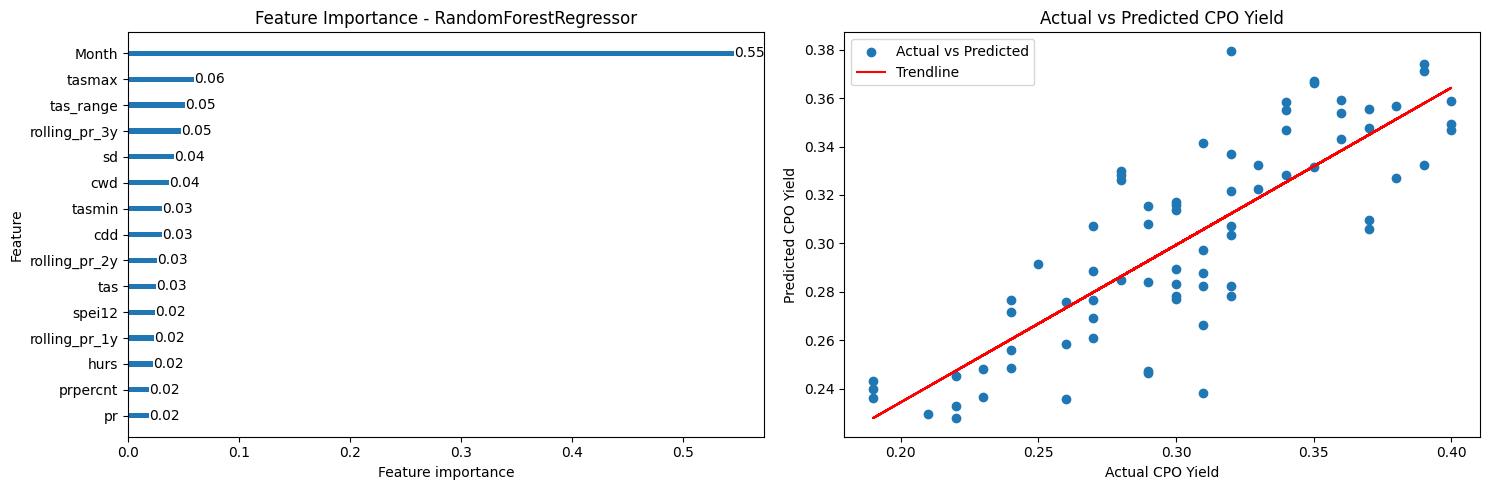

In [46]:
import numpy as np
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual CPO Yield')
ax[1].set_ylabel('Predicted CPO Yield')
ax[1].set_title('Actual vs Predicted CPO Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()

In [49]:
# get model parameters
for p in best_model.get_params():
    print(f'{p}: {best_model.get_params()[p]}')

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [50]:
param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}


In [51]:
from sklearn.model_selection import RandomizedSearchCV


tuned_model = RandomizedSearchCV(estimator = best_pipeline, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, scoring='r2')
tuned_model.fit(X_train, y_train)
print("Best Parameters:", tuned_model.best_params_)
print("Best Score:", tuned_model.best_score_)
for p in tuned_model.best_params_:
    print(f'{p}: {tuned_model.best_params_[p]}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__n_estimators': 400, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 10}
Best Score: 0.6265239693378302
model__n_estimators: 400
model__min_samples_split: 5
model__min_samples_leaf: 1
model__max_features: None
model__max_depth: 10


In [53]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Predict using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate evaluation metrics for the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# Create a comparison table using Pandas DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'base_model': [best_model_metrics['MSE Mean'], best_model_metrics['RMSE Mean'], best_model_metrics['MAE Mean'], best_model_metrics['R2 Mean']],
    'tuned_model': [mse_tuned, rmse_tuned, mae_tuned, r2_tuned],
    'improvement %': [(best_model_metrics['MSE Mean'] - mse_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (best_model_metrics['RMSE Mean'] - rmse_tuned)/best_model_metrics['RMSE Mean'] * 100,
                    (best_model_metrics['MAE Mean'] - mae_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (r2_tuned - best_model_metrics['R2 Mean'])/best_model_metrics['R2 Mean'] * 100]

})
# Display the comparison table
print('Comparison of CPO model')
print(comparison_df)
print()
print(f'Improvement')

Comparison of CPO model
  Metric  base_model  tuned_model  improvement %
0    MSE    0.001014     0.000963       0.203479
1   RMSE    0.031681     0.031031       2.049698
2    MAE    0.025055     0.025245      -0.760181
3     R2    0.635140     0.667684       5.123936

Improvement


In [54]:
import joblib

joblib.dump(tuned_model, 'cpo_yield_model5.pkl')


['cpo_yield_model5.pkl']

In [55]:
model4 = joblib.load('cpo_yield_model4.pkl')
v4 = model4.predict(X)

model5 = joblib.load('cpo_yield_model5.pkl')
v5 = model5.predict(X)

print(f'model v4: {r2_score(y, v4)}')
print(f'model v5: {r2_score(y, v5)}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


model v4: -0.35599814682334197
model v5: 0.8772232928967881
